In [42]:
# Import packages
import os

import earthpy as et
import geopandas as gpd
import matplotlib.pyplot as plt

In [43]:
# Download data
et.data.get_data('spatial-vector-lidar')

# Set working directory
working_dir = os.path.join(et.io.HOME, 'earth-analytics', 'data')
if not os.path.exists(working_dir):
    print('Working directory {} does not exist. Creating...'
          .format(working_dir))
    os.makedirs(working_dir)

os.chdir(working_dir)
print('Working directory changed to {}'.format(working_dir))

Working directory changed to /Users/elsa/earth-analytics/data


In [44]:
%%bash
find spatial-vector-lidar/california

spatial-vector-lidar/california
spatial-vector-lidar/california/madera-county-roads
spatial-vector-lidar/california/madera-county-roads/tl_2013_06039_roads.shx
spatial-vector-lidar/california/madera-county-roads/tl_2013_06039_roads.shp
spatial-vector-lidar/california/madera-county-roads/tl_2010_05143_roads.shp.xml
spatial-vector-lidar/california/madera-county-roads/tl_2013_06039_roads.dbf
spatial-vector-lidar/california/madera-county-roads/tl_2013_06039_roads.shp.xml
spatial-vector-lidar/california/madera-county-roads/metadata.html
spatial-vector-lidar/california/madera-county-roads/tl_2013_06039_roads.prj
spatial-vector-lidar/california/neon-sjer-site
spatial-vector-lidar/california/neon-sjer-site/2013
spatial-vector-lidar/california/neon-sjer-site/2013/insitu
spatial-vector-lidar/california/neon-sjer-site/2013/insitu/veg_metadata_desc_DataInstitute2016.csv
spatial-vector-lidar/california/neon-sjer-site/2013/insitu/veg_chemistry
spatial-vector-lidar/california/neon-sjer-site/2013/insi

In [45]:
# Set California data path
ca_path = os.path.join(
    'spatial-vector-lidar', 'california')
sjer_vector_path = os.path.join(
    ca_path, 'neon-sjer-site', 'vector_data')

# Set Madera County Roads path
madera_roads_path = os.path.join(
    ca_path, 'madera-county-roads', 'tl_2013_06039_roads.shp')

# Set SJER site centroids path
sjer_sites_path = os.path.join(
    sjer_vector_path, 'SJER_plot_centroids.shp')

# Set SJER area of interest path
sjer_aoi_path = os.path.join(
    sjer_vector_path, 'SJER_crop.shp')

# Set California Counties path
ca_counties_path = os.path.join(
    ca_path, 'CA_Counties', 'CA_Counties_TIGER2016.shp')

# Set Global Roads path
ww_roads_path = os.path.join(
    'spatial-vector-lidar', 'global', 'ne_10m_roads', 'ne_10m_roads.shp')

path_list = [
    madera_roads_path, sjer_sites_path, 
    sjer_aoi_path, ca_counties_path]

for pth in path_list:
    if os.path.exists(pth):
        print('{} exists'.format(pth))
    else:
        print('{} does not exist.'.format(pth))

spatial-vector-lidar/california/madera-county-roads/tl_2013_06039_roads.shp exists
spatial-vector-lidar/california/neon-sjer-site/vector_data/SJER_plot_centroids.shp exists
spatial-vector-lidar/california/neon-sjer-site/vector_data/SJER_crop.shp exists
spatial-vector-lidar/california/CA_Counties/CA_Counties_TIGER2016.shp exists


In [46]:
# Import data to GeoDataFrames
madera_roads_full_gdf = gpd.read_file(madera_roads_path)

# Locate NA rows
na_rows = ~madera_roads_full_gdf.RTTYP.isin(['M', 'S', 'C'])
madera_roads_full_gdf.loc[na_rows, 'RTTYP'] = 'Unknown'
madera_roads_full_gdf.RTTYP.unique()

array(['M', 'Unknown', 'S', 'C'], dtype=object)

In [47]:
sjer_sites_full_gdf = gpd.read_file(sjer_sites_path)

<AxesSubplot:>

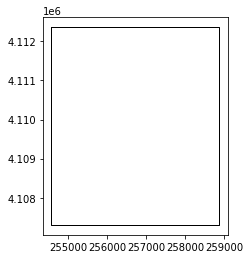

In [48]:
sjer_aoi_gdf = gpd.read_file(sjer_aoi_path)
sjer_aoi_gdf.plot(facecolor='none')

<AxesSubplot:>

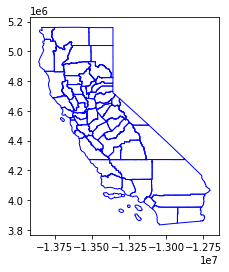

In [49]:
ca_counties_gdf = gpd.read_file(ca_counties_path)
ca_counties_gdf.plot(facecolor='none', edgecolor='blue')

In [50]:
ww_roads_gdf = gpd.read_file(ww_roads_path)

In [51]:
# Set CRSs to match
madera_roads_full_gdf = madera_roads_full_gdf.to_crs(sjer_aoi_gdf.crs)

if all([gdf.crs==sjer_aoi_gdf.crs 
        for gdf 
        in [madera_roads_full_gdf, sjer_sites_full_gdf]]):
    print('All CRSs match!')

All CRSs match!


<AxesSubplot:>

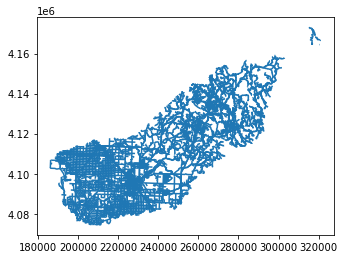

In [52]:
madera_roads_full_gdf.plot()

<AxesSubplot:>

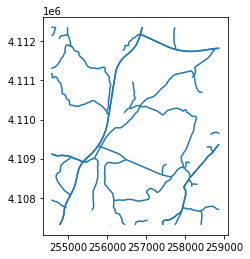

In [53]:
madera_roads_gdf = madera_roads_full_gdf.clip(sjer_aoi_gdf)
madera_roads_gdf.plot()

<AxesSubplot:>

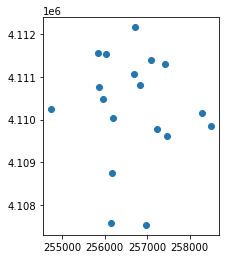

In [54]:
sjer_sites_full_gdf.plot()

<AxesSubplot:>

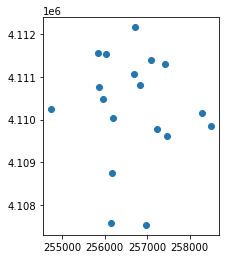

In [55]:
sjer_sites_gdf = sjer_sites_full_gdf.clip(sjer_aoi_gdf)
sjer_sites_gdf.plot()

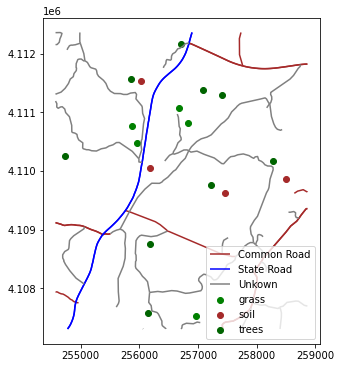

In [56]:
# Create plot
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

# Add road layers to plot
road_color_dict = {
    'M': 'brown',
    'S': 'blue',
    'Unknown': 'grey'}
road_type_dict = {
    'M': 'Common Road',
    'S': 'State Road',
    'Unknown': 'Unkown'}

for rttyp, gdf in madera_roads_gdf.groupby('RTTYP'):
    gdf.plot(ax=ax, 
             color=road_color_dict[rttyp], 
             label=road_type_dict[rttyp])
    
# Add Site layers to the plot
site_color_dict = {
    'grass': 'green',
    'soil': 'brown',
    'trees': 'darkgreen'
}
for plot_type, gdf in sjer_sites_gdf.groupby('plot_type'):
    gdf.plot(
        ax=ax,
        color=site_color_dict[plot_type],
        label=plot_type)
    
ax.legend()

Major Highway
Road
Secondary Highway


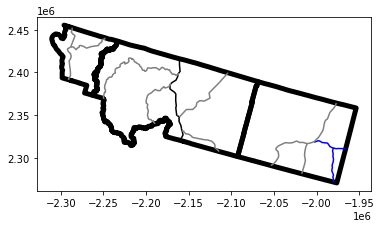

In [57]:
three_counties_utm_gdf = (
    ca_counties_gdf
    [ca_counties_gdf.NAME.isin(['Del Norte', 'Modoc', 'Siskiyou'])])

# Reproject to 5070
three_counties_5070_gdf = three_counties_utm_gdf.to_crs(5070)
ww_roads_5070_gdf = ww_roads_gdf.to_crs(5070)


# Clip roads
roads_5070_gdf = ww_roads_5070_gdf.clip(three_counties_5070_gdf)

# Join with county
roads_by_county_gdf = roads_5070_gdf.sjoin(
    three_counties_5070_gdf, how='inner', predicate='intersects')

# Plot
ax = three_counties_5070_gdf.plot(facecolor="none", linewidth=5)

# Add road layers
road_type_color_dict = {
    'Major Highway': 'black',
    'Road': 'blue',
    'Secondary Highway': 'grey'
}
for road_type, gdf in roads_by_county_gdf.groupby('type'):
    print(road_type)
    gdf.plot(
        ax=ax, 
        color=road_type_color_dict[road_type],
        label=road_type)

In [65]:
roads_by_county_gdf['NAME']

1135         Modoc
48916        Modoc
52           Modoc
48926        Modoc
1003         Modoc
49044     Siskiyou
3767      Siskiyou
3766      Siskiyou
48954     Siskiyou
48977     Siskiyou
1479      Siskiyou
1533      Siskiyou
3768     Del Norte
60       Del Norte
59       Del Norte
1434     Del Norte
1427     Del Norte
Name: NAME, dtype: object

In [72]:
road_length_county_gdf = roads_by_county_gdf[['NAME', 'geometry']].copy()
road_length_county_gdf.insert(1, 'length', roads_by_county_gdf.length)
road_length_county_gdf

1135     LINESTRING (-2017325.564 2281182.339, -2013801...
48916    LINESTRING (-1980349.868 2311452.867, -1981233...
52       LINESTRING (-2011102.332 2316513.712, -2016199...
48926    LINESTRING (-2003051.344 2318602.110, -2001649...
1003     LINESTRING (-1976820.097 2364156.257, -1978377...
49044    LINESTRING (-2114248.317 2307338.793, -2115663...
3767     LINESTRING (-2160474.597 2320495.776, -2157854...
3766     LINESTRING (-2158532.334 2334564.009, -2159036...
48954    LINESTRING (-2189831.567 2339681.014, -2189853...
48977    LINESTRING (-2249884.570 2368938.441, -2249782...
1479     MULTILINESTRING ((-2160917.890 2347773.898, -2...
1533     LINESTRING (-2160848.904 2416102.147, -2160776...
3768     LINESTRING (-2291277.647 2391592.541, -2290823...
60       LINESTRING (-2290541.823 2391374.931, -2290741...
59       LINESTRING (-2248076.012 2440698.299, -2248715...
1434     LINESTRING (-2248073.255 2440723.283, -2248076...
1427     LINESTRING (-2288452.781 2429779.000, -2283525.

In [73]:
road_length_county_gdf.groupby('NAME').sum()

,length
NAME,
Del Norte,121307.565363
Modoc,245029.146972
Siskiyou,472427.949970


In [74]:
road_length_county_gdf.crs

<Projected CRS: EPSG:5070>
Name: NAD83 / Conus Albers
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - CONUS onshore - Alabama; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming.
- bounds: (-124.79, 24.41, -66.91, 49.38)
Coordinate Operation:
- name: Conus Albers
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [18]:
%%bash
ls earthpy-downloads/ne_110m_admin_0_countries

ne_110m_admin_0_countries.README.html
ne_110m_admin_0_countries.VERSION.txt
ne_110m_admin_0_countries.cpg
ne_110m_admin_0_countries.dbf
ne_110m_admin_0_countries.prj
ne_110m_admin_0_countries.shp
ne_110m_admin_0_countries.shx


<AxesSubplot:>

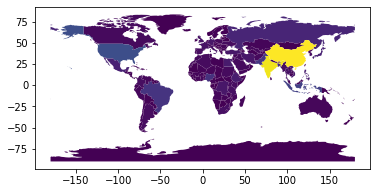

In [19]:
countries_url = (
    'https://naturalearth.s3.amazonaws.com/110m_cultural/'
    'ne_110m_admin_0_countries.zip')
et.data.get_data(url=countries_url)

countries_path = os.path.join(
    'earthpy-downloads',
    'ne_110m_admin_0_countries',
    'ne_110m_admin_0_countries.shp')
countries_gdf = gpd.read_file(countries_path)

pop_col_name = 'POP_EST'
countries_gdf.plot(column=pop_col_name)

<AxesSubplot:>

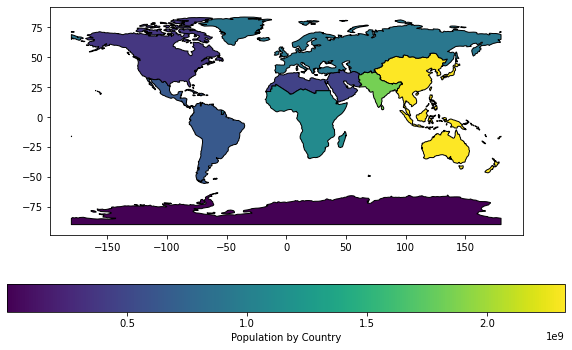

In [20]:
regions_gdf = countries_gdf.dissolve('REGION_WB', aggfunc='sum')

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
regions_gdf.plot(
    ax=ax,
    column=pop_col_name,
    edgecolor='black',
    legend=True,
    legend_kwds={'label': "Population by Country",
                 'orientation': "horizontal"})

Made with Natural Earth. Free vector and raster map data @ naturalearthdata.com.

In [89]:
import pandas as pd

ca_counties_4326_gdf = ca_counties_gdf.to_crs(ww_roads_gdf.crs)

ca_roads_by_county = (
    ww_roads_gdf
    .sjoin(ca_counties_4326_gdf, how='inner', predicate='intersects'))

county_road_gdfs = []
for county, road_gdf in ca_roads_by_county.groupby('NAME'):
    clipped = (
        road_gdf
        .clip(ca_counties_4326_gdf[ca_counties_4326_gdf.NAME==county]))
    county_road_gdfs.append(road_gdf)

county_road_gdf = gpd.GeoDataFrame(pd.concat(county_road_gdfs))
county_road_gdf.length

/var/folders/dn/99vk45cd5n56wsnl3hxc1bw40000gp/T/ipykernel_32044/2465118331.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  county_road_gdf.length


1000     0.225836
1001     0.191573
1896     0.148637
1897     0.279894
1902     0.367942
           ...   
1131     0.488385
3755     0.408192
3857     0.132998
49023    0.564553
49036    0.356144
Length: 575, dtype: float64